# PCA on Faces Dataset

In this assignment, we will use PCA for dimensionality reduction on the MIT Face Recognition Dataset (https://courses.media.mit.edu/2004fall/mas622j/04.projects/faces/). The following code collects images from rawdata and stores them in a 128x128x(number of images) tensor - image_collection.

See the following link for how to use PCA in scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


In [1]:
import os
import skimage
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure

IMAGE_SIZE = 128
directory  = os.fsencode('rawdata/')
num_files  = len([file for file in os.listdir(directory) \
                  if os.path.isfile(os.path.join(directory, file))])
image_collection = np.zeros((IMAGE_SIZE,IMAGE_SIZE,num_files))
image_collection2 = np.zeros((num_files,IMAGE_SIZE,IMAGE_SIZE))
count = 0

for file in os.listdir(directory):
    filename   = os.fsdecode(file)
    temp_image = np.fromfile('rawdata/'+filename, dtype='uint8', sep="")
    ratio      = temp_image.shape[0]/(IMAGE_SIZE*IMAGE_SIZE)
    if ratio > 1:
        temp_image = np.reshape(temp_image, (IMAGE_SIZE*int(np.sqrt(ratio)), IMAGE_SIZE*int(np.sqrt(ratio))))
        temp_image = skimage.measure.block_reduce(temp_image, (int(np.sqrt(ratio)),int(np.sqrt(ratio))), np.mean)
    image_collection[:,:,count] = np.reshape(temp_image,(IMAGE_SIZE,IMAGE_SIZE))
    image_collection2[count,:,:] = np.reshape(temp_image,(IMAGE_SIZE,IMAGE_SIZE))
    count += 1

image_collection = image_collection[:,:,:count]
image_collection2 = image_collection2[:count,:,:]
print('Shape of collection1: ', image_collection.shape)
print('Shape of collection2: ', image_collection2.shape)


Shape of collection1:  (128, 128, 3993)
Shape of collection2:  (3993, 128, 128)


# Problem 1

Recall that PCA requires centered data(zero mean). Center B and display the mean image in gray scale using matplotlib

(128, 128, 3993)
(128, 128)


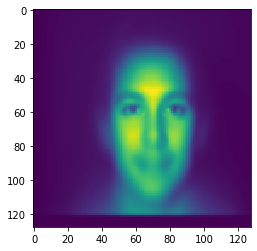

(3993, 128, 128)
(128, 128)


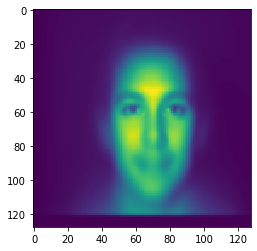

In [25]:
#========Your code here ======
print(image_collection.shape)
im_mean = image_collection.mean(axis=(2))
print(im_mean.shape)
for i in range(im_mean.shape[0]):
    for j in range(im_mean.shape[1]):
        for k in range(image_collection.shape[2]):
            image_collection[i, j, k] -= im_mean[i, j]
            
plt.imshow(im_mean)
#==============================
plt.show()


#========Your code here ======
print(image_collection2.shape)
im_mean2 = image_collection2.mean(axis=(0))
print(im_mean2.shape)
for i in range(im_mean.shape[0]):
    for j in range(im_mean.shape[1]):
        for k in range(image_collection2.shape[0]):
            image_collection2[k, i, j] -= im_mean[i, j]
            
plt.imshow(im_mean2)
#==============================
plt.show()

# Problem 2

Perform PCA on the images using sklearn. Plot the total percentage of variance explained versus number of components. Finally plot the singular values when number of components is 500. Justify the plots.

## Answer:
We can observe the total percentage of variance explained. As number of component increase, the total percentage of variance explained shows Logarithmic growth. PCA lets the data has maximum variance on the axis of the first component, and we can see that from the second plot. The first plot is the cumulative version of the first plot. We can observe from these plots that with more component, the transformed data will lose less information. However, after the total percentage of variance explained reachs 80%, the benefit of adding additional components is limited. 

Num_comp is  2
  TVE shape: (2,)
Num_comp is  5
  TVE shape: (5,)
Num_comp is  7
  TVE shape: (7,)
Num_comp is  10
  TVE shape: (10,)
Num_comp is  20
  TVE shape: (20,)
Num_comp is  30
  TVE shape: (30,)
Num_comp is  40
  TVE shape: (40,)
Num_comp is  50
  TVE shape: (50,)
Num_comp is  100
  TVE shape: (100,)
Num_comp is  500
  TVE shape: (500,)


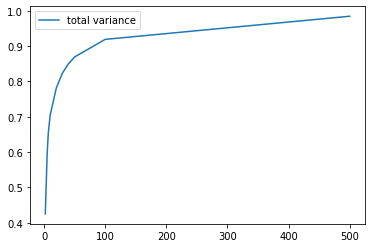

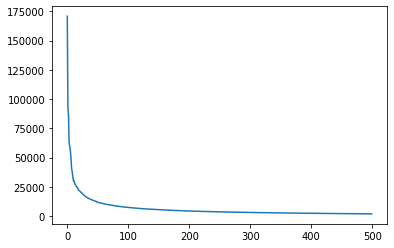

In [13]:
num_comp = [2,5,7,10,20,30,40,50,100,500]
#========Your code here ======
from sklearn.decomposition import PCA


d2_train_dataset = image_collection2.reshape((num_files,IMAGE_SIZE*IMAGE_SIZE))
total_variance_explained = []
for num in num_comp:
    print('Num_comp is ', num)
    pca = PCA(n_components=num).fit(d2_train_dataset)
    total_variance_explained.append(np.sum(pca.explained_variance_ratio_))
    #total_variance_explained = pca.explained_variance_ratio_
    print('  TVE shape:', pca.explained_variance_ratio_.shape)
    if num==500:
        singular_values = pca.singular_values_
#     print(pca.explained_variance_ratio_)
#     plt.plot(range(num), pca.explained_variance_ratio_, label='total variance')
#     plt.show()

#==============================
plt.figure(1)
plt.plot(num_comp,total_variance_explained,label='total variance')
plt.legend()
plt.show()
plt.figure(2)
plt.plot(range(500),singular_values)
plt.show()

# Problem 3

Display the first 5 principal components as images in gray scale using matplotlib. Explain your observations.

## Answer
We can see a face clearly in the first plot. Still a face in the second plot, but a blurred one. Barely see a face in the third plot, but we can see the contour. There is a complement face in the forth and fifth plot. That could represent the detail in a face which has less variance. In conclusion, we can see that the first plot can give us the most information, and the information decreases afterwards.

# 0 plot:


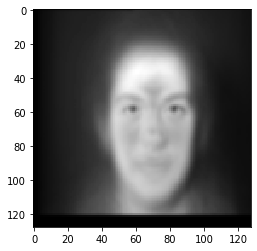

# 1 plot:


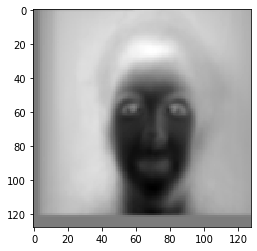

# 2 plot:


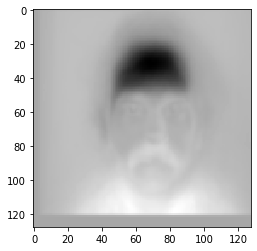

# 3 plot:


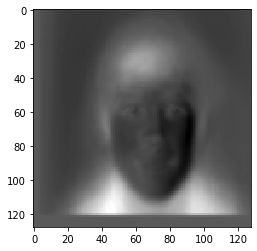

# 4 plot:


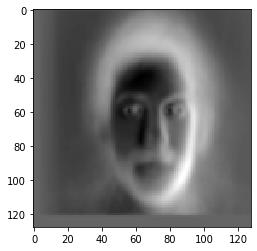

In [35]:
#========Your code here ======
pca = PCA(n_components=500).fit(d2_train_dataset)
comp = pca.components_
for i in range(5):
    print('#', i, 'plot:')
    tmp_im = np.reshape(comp[i], (IMAGE_SIZE,IMAGE_SIZE))
    plt.imshow(tmp_im, cmap="gray") 
    plt.show() 
    
#==============================

# K-means for Image Quantization

In this part of the assignment you will implement your own k-means algorithm and use it for image quantization. 

As we know image consists of pixels. For standard colored image, each pixel is a 3D vector where each component is an integer from 0 to 255 which represents the intensity of red, green and blue light. 

Sometimes we may want to reduce the number of colors in an image. One naive way is to simply reduce the quantization bits of pixels: instead of using 0-255 which could be written as 8 bit binary, we simply reduce the number of bits (for example, using 4 bits means that we use integers 0-15 instead). However, this method may not capture the original color of the image as you will see in an example.

K-means provides a better alternative: we treat each pixel as a vector, and try to find $k$ colors (centroids) that best represent the colors in the image. 

The following code reads an image and converts it to a set of vectors. You may need to install OpenCV for python. To install, simply run `pip install opencv-python` in your terminal/Anaconda prompt

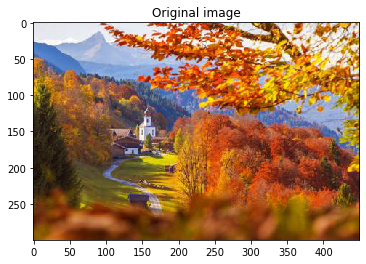

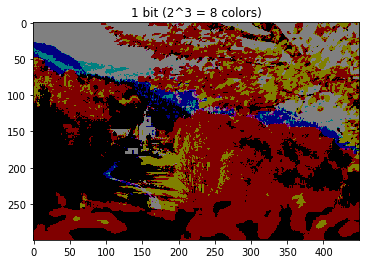

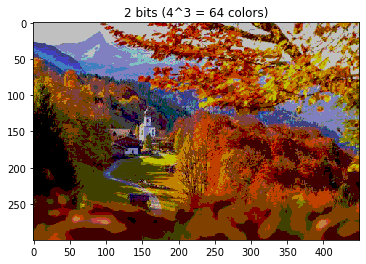

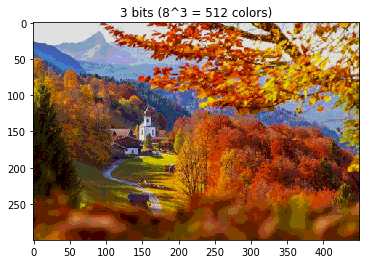

In [2]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("image.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Some useful parameters
height = img.shape[0]
width = img.shape[1]
n = height * width

# Reshaping the image into vectors. 
vec_img = img.reshape((-1, 3))
vec_img = np.float32(vec_img)

# Display original and quantized images. 
plt.figure()
plt.title("Original image")
plt.imshow(img)

plt.figure()
quantized_img = np.uint8(np.float32(img)/128)*128
plt.title("1 bit (2^3 = 8 colors)")
plt.imshow(quantized_img)

quantized_img = np.uint8(np.float32(img)/64)*64
plt.figure()
plt.title("2 bits (4^3 = 64 colors)")
plt.imshow(quantized_img)

quantized_img = np.uint8(np.float32(img)/32)*32
plt.figure()
plt.title("3 bits (8^3 = 512 colors)")
plt.imshow(quantized_img)


# Problem 4: Implement your own k-means algorithm

Now you will implement your own k-means algorithm. Random initialization of centroids is sufficient for this assignment. You are NOT allowed to use any k-means imlementations in any existing libraries, including but not limited to those in OpenCV and Scikit-learn. Your algorithm takes the following input:

$K$ - the number of clusters/centroids

$vec$ - the set of vectors ($n\times d$ array where $n$ is the number of vectors and $d$ is the dimension of each vector)

$eps$ - algorithm should stop when the average distance change of centroids is smaller than this number. More specifically, let $c_k^{(i)}$ be the $k$'th centroid in iteration $i$, the algorithm should stop when:
$$
\frac{1}{K}\sum_{k=1}^K \|c_k^{(i)}-c_k^{(i-1)}\|^2<eps
$$
$max\_iter$ - maximum number of iterations

Your algorithm should stop when either of the two criteria (change of centroids less than $eps$, or maximum iteration) is satisfied. 

It should return two values:

$centroids$ - the centroids for each cluster arranged in a $K\times d$ array

$labels$ - the labels of each vector, an $n$ dimensional 1-d array. Each label should be an integer from $\{0, ..., K-1\}$

In [3]:
def k_means(vec, K, eps, max_iter):
    n = vec.shape[0]
    d = vec.shape[1]
    centroids = np.zeros((K, d))
    labels = np.zeros(n).astype(int)
    
    #============ Your code here ====================
    
    for i in range(K):
        centroids[i,:] = vec[int(n/K*i),:]
        
    count_iter = 0
    while count_iter < max_iter:
        count_iter += 1
        dist=np.array(np.zeros([n,K]))
        for k in range(K):
            c=centroids[k,:]
            dist[:,k] = np.linalg.norm(vec-c,axis=1)
        prev_Centroid = np.copy(centroids)
        centroids_index = dist.argmin(axis=1)
        for k in range(K):
            m = np.mean(vec[(centroids_index==k), :], axis=0)
            centroids[k,:] = m
            
        if np.sum(np.square(prev_Centroid-centroids))/K < eps:
            break
            
    for k in range(K):
        c=centroids[k,:]
        dist[:,k] = np.linalg.norm(vec-c,axis=1)
    labels = dist.argmin(axis=1)
    print('running: K=', K)
    #=============== End code =====================
    
    return centroids, labels

print(vec_img.shape)
k_means(vec_img, 4, 1e-6, 10)

(135000, 3)
running: K= 4


(array([[180.34631348, 183.4347229 , 202.74229431],
        [203.87237549, 125.94702148,  36.84370804],
        [142.33006287,  74.02879333,  23.9981041 ],
        [ 78.05771637,  54.1309433 ,  41.42570114]]),
 array([0, 0, 0, ..., 3, 3, 3]))

Now comes the fun part: display the quantized image for $K=4, 8, 16, 32$. You will observe that k-means quantization achieves far better results than the naive quantization strategy with much less number of colors. 

running: K= 4
running: K= 8
running: K= 16
running: K= 32


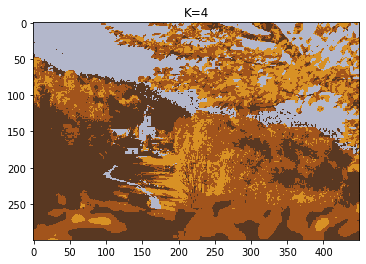

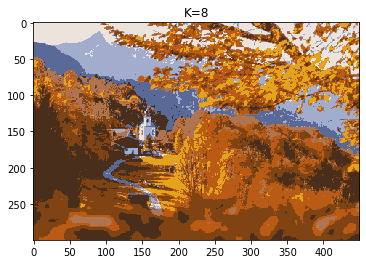

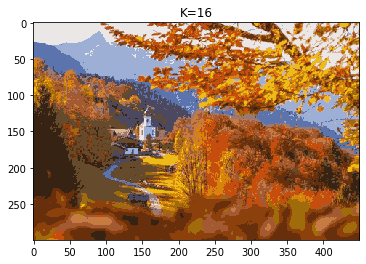

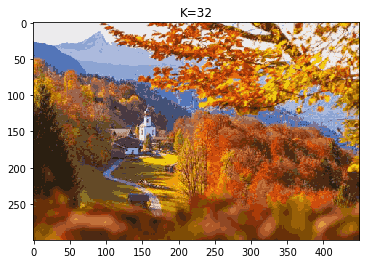

In [4]:
K = [4, 8, 16, 32]
eps = 1e-6
max_iter = 10000

for k in K:
    plt.figure()
    centroids, labels = k_means(vec_img, k, eps, max_iter)
    compressed_vec = centroids[labels, :]
    compressed_img = compressed_vec.reshape(img.shape)
    compressed_img = np.uint8(compressed_img)
    plt.imshow(compressed_img)
    plt.title("K=" + str(k) )

# Problem 5: Try with your own image (this part is not graded)

240 240
(57600, 3)
running: K= 4
running: K= 8
running: K= 16
running: K= 32


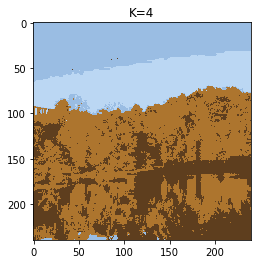

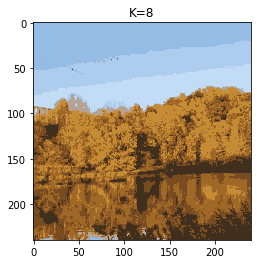

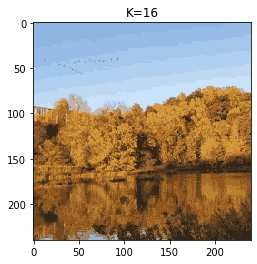

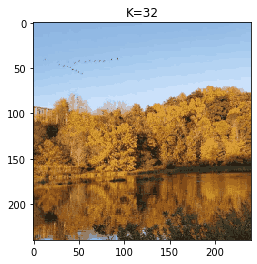

In [11]:
img = cv2.imread("image2.jpg")
img = cv2.resize(img, (240, 240), interpolation = cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Some useful parameters
height = img.shape[0]
width = img.shape[1]
n = height * width
print(height, width)

# Reshaping the image into vectors. 
vec_img = img.reshape((-1, 3))
vec_img = np.float32(vec_img)
print(vec_img.shape)

# K = [4, 8, 16, 32]
# eps = 1e-6
# max_iter = 10000

for k in K:
    plt.figure()
    centroids, labels = k_means(vec_img, k, eps, max_iter)
    compressed_vec = centroids[labels, :]
    compressed_img = compressed_vec.reshape(img.shape)
    compressed_img = np.uint8(compressed_img)
    plt.imshow(compressed_img)
    plt.title("K=" + str(k) )